In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, confusion_matrix, roc_curve, auc
seed=0

## Logistic Regression

In [2]:
# This dataset describes grains of rice in terms of visual properties.
# The class is the variety of rice, either Cammeo or Osmancık
# https://archive.ics.uci.edu/ml/datasets/Rice+%28Cammeo+and+Osmancik%29
# (Actually downloaded the data from the paper's website.)
rice = pd.read_csv("Rice_Osmancik_Cammeo_Dataset.csv")
rice.head()

,AREA,PERIMETER,MAJORAXIS,MINORAXIS,ECCENTRICITY,CONVEX_AREA,EXTENT,CLASS
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo


In [3]:
# Check out class distribution

rice.CLASS.value_counts()

Osmancik    2180
Cammeo      1630
Name: CLASS, dtype: int64

In [13]:
#Baseline accuracy? (i.e. accuracy for always guessing the majority class)

# baselineacc = 2180 / (2180 + 1630)

A = rice.CLASS[rice['CLASS']=='Osmancik'].count() # majority class
B = rice.CLASS[rice['CLASS']=='Cammeo'].count()

baselineacc = A/(A+B) # the classifier you train must beat this number else no point in training one

print('Baseline Accuracy: '+str((baselineacc*100).round(1))+'%')

Baseline Accuracy: 57.2%


In [14]:
# Split data, train logistic regression

X = rice.drop('CLASS', axis='columns').values
y = rice.CLASS.values

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, random_state=seed)

In [15]:
# Fit model, print coefficients
ricelr = LogisticRegression(penalty='none').fit(Xtrain,ytrain)

print(f"Intercept:\n {ricelr.intercept_.round(3)} \nCoefficients:\n {ricelr.coef_.round(3)}")
# This tells you how each one of the features relates to the probability that an example is from the positive or negative class  

Intercept:
 [0.003] 
Coefficients:
 [[ 0.006  0.145 -0.241  0.392  0.001 -0.01   0.003]]


In [16]:
# Predict manually
sigmoid = lambda x: 1 / (1 + np.exp(-x)) # a small anonymous function that can take any number of args but can only have one expression
z = ricelr.intercept_ + Xtest@ricelr.coef_.T
z.round(3)

array([[  3.342],
       [-10.379],
       [ -0.099],
       ...,
       [ -4.002],
       [  1.715],
       [ -8.586]])

Read more about Lambda [here](https://www.w3schools.com/python/python_lambda.asp).

In [19]:
# now let's see how probabilities look like:
sigmoid(z).round(2)

array([[0.97],
       [0.  ],
       [0.48],
       ...,
       [0.02],
       [0.85],
       [0.  ]])

In [20]:
# or you can use a built-in function to see the probabilities without hard coding:
ricelr.predict_proba(Xtest).round(2)
# first column: probabilities for class 0 (one minus second column),
# second column: probabilities for class 1 (calculated above)

array([[0.03, 0.97],
       [1.  , 0.  ],
       [0.52, 0.48],
       ...,
       [0.98, 0.02],
       [0.15, 0.85],
       [1.  , 0.  ]])

In [21]:
# Get label predictions
ytest_hat = ricelr.predict(Xtest)
ytest_hat

array(['Osmancik', 'Cammeo', 'Cammeo', ..., 'Cammeo', 'Osmancik',
       'Cammeo'], dtype=object)

## Evaluating Classifiers

In [25]:
# Calculate performance measures from scratch
# TP: true positives 
# TN: true negatives 
# FP: False positives 
# FN: False negatives

def compute_performance(yhat, y, classes):
    # First, get tp, tn, fp, fn
    tp = sum(np.logical_and(yhat == classes[1], y == classes[1]))
    tn = sum(np.logical_and(yhat == classes[0], y == classes[0]))
    fp = sum(np.logical_and(yhat == classes[1], y == classes[0]))
    fn = sum(np.logical_and(yhat == classes[0], y == classes[1]))

    print(f"tp: {tp} tn: {tn} fp: {fp} fn: {fn}")
    
    # Accuracy
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    # Precision
    # "Of the ones I labeled +, how many are actually +?"
    precision = tp / (tp + fp)
    
    # Recall
    # "Of all the + in the data, how many do I correctly label?"
    recall = tp / (tp + fn)    
    
    # Sensitivity
    # "Of all the + in the data, how many do I correctly label?"
    sensitivity = recall
    
    # Specificity
    # "Of all the - in the data, how many do I correctly label?"
    specificity = tn / (fp + tn)
    
    # Print results
    
    print("Accuracy:",round(acc,3),"Recall:",round(recall,3),"Precision:",round(precision,3),
          "Sensitivity:",round(sensitivity,3),"Specificity:",round(specificity,3))

compute_performance(ytest_hat, ytest, ricelr.classes_)

# Let's compare against base-line accuracy:
print('\nBaseline Accuracy: ', baselineacc.round(3))

tp: 1001 tn: 773 fp: 81 fn: 50
Accuracy: 0.931 Recall: 0.952 Precision: 0.925 Sensitivity: 0.952 Specificity: 0.905

Baseline Accuracy:  0.572


In [26]:
# Now let's experiment by adjusting the decision threshold
threshold = 0.1
ytest_prob = ricelr.predict_proba(Xtest)

# ytest_prob

# ytest_prob[:,1].round(3) > threshold

# [(ytest_prob[:,1] > threshold).astype(int)] # turn them into 0 and 1

# ricelr.classes_ # element 0 for label class 0 and element 1 for label class 1

yhat = ricelr.classes_[(ytest_prob[:,1] > threshold).astype(int)]

# yhat

compute_performance(yhat, ytest, ricelr.classes_)

tp: 1040 tn: 613 fp: 241 fn: 11
Accuracy: 0.868 Recall: 0.99 Precision: 0.812 Sensitivity: 0.99 Specificity: 0.718


Text(0, 0.5, 'TP Rate')

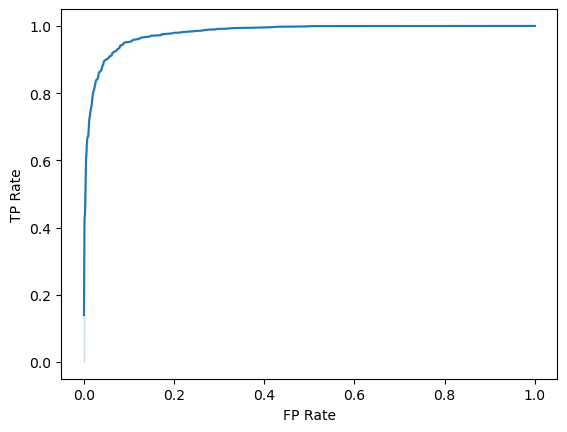

In [27]:
# Ranking based criterion: Receiver Operating Characteristic (ROC) curve using sklearns:
  
fpr, tpr, _ = roc_curve(ytest, ytest_prob[:,1], pos_label=ricelr.classes_[1]) # 2nd arg: ranking score, 3rd arg: "Osmancik"
ax =sns.lineplot(x=fpr,y=tpr)
ax.set_xlabel("FP Rate")
ax.set_ylabel("TP Rate")

In [29]:
# Area under ROC (AUROC)
auc(fpr,tpr).round(3)

0.98

## Multiclass Logistic Regression

In [30]:
# Read data
iris = pd.read_csv("iris.csv")
iris.head()

,Sepal-length,Sepal-width,Petal-length,Petal-width,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [32]:
# Check out class distribution
iris.Species.value_counts()
# we have 3 balanced classes

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64

In [33]:
# Create y and X. Not going to split these data for this demonstration.
X = iris.drop("Species", axis="columns")
y = iris.Species.values

In [34]:
# Note that unlike our convention in class, sklearn makes a parameter vector
# for every class (not just first K-1) even though it is redundant.
IRISLR = LogisticRegression(penalty='none')
irislr = IRISLR.fit(X,y)
print(f"Intercepts:\n {irislr.intercept_.round(3)} \n\nCoefficients:\n {irislr.coef_.round(3)}")

Intercepts:
 [  3.978  19.33  -23.308] 

Coefficients:
 [[  7.353  20.398 -30.264 -14.143]
 [ -2.444  -6.858  10.417  -2.071]
 [ -4.909 -13.539  19.846  16.215]]


In [35]:
yhat = irislr.predict(X)
# yhat
yhat_probs = irislr.predict_proba(X)
# yhat_probs.round(3)

In [36]:
confusion_matrix(yhat,y).T
# We transpose to get it in the format we saw in slides:
# Rows: Predicted labels
# Columns: True labels 

array([[50,  0,  0],
       [ 0, 49,  1],
       [ 0,  1, 49]])

## Regularization

In [39]:
# l2: sum of the squares of the values of the coefficients
# C: smaller values specify stronger regularization
IRISLR = LogisticRegression(penalty='l2', solver='newton-cg', C=0.01) # Experiment different values for C

irislr = IRISLR.fit(X,y)
print(f"Intercepts:\n {irislr.intercept_.round(3)} \n\nCoefficients:\n {irislr.coef_.round(3)}")

yhat = irislr.predict(X)
yhat_probs = irislr.predict_proba(X)
confusion_matrix(yhat,y).T

Intercepts:
 [ 2.193  0.219 -2.411] 

Coefficients:
 [[-0.137  0.096 -0.435 -0.178]
 [-0.001 -0.102  0.087 -0.003]
 [ 0.138  0.006  0.348  0.182]]


array([[50,  0,  0],
       [ 1, 32, 17],
       [ 0,  1, 49]])